# Looking at threshold splitting for the sentiment confidence from flair

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,date,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,2020-02-10,7,07:03:44,7,0,1,Nevada,NV,32003,1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,2020-02-10,7,07:04:49,7,0,1,New York,NY,36081,1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,2020-02-10,7,07:05:30,7,0,1,Arizona,AZ,04013,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,2020-02-10,7,07:10:48,7,1,0,Arkansas,AR,05119,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,2020-02-10,7,07:11:11,7,1,0,Arkansas,AR,05119,1


In [2]:
raw.columns

Index(['id_str', 'created_at', 'follower_count', 'friends_count', 'statefips',
       'countyfips', 'countyname', 'is_urban', 'ogtext', 'cleantext',
       'mentions', 'hashtags', 'pos', 'ner', 'sentiment', 'sent_confidence',
       'date', 'week', 'time', 'hour', 'is_negative', 'is_positive',
       'state_name', 'state_abv', 'fips', 'count'],
      dtype='object')

# Testing splitting at specific thresholds

In [13]:
thresholds = [0.8, 0.9, 0.95]
for thresh in thresholds:
    raw[f't:{thresh}'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]


raw.head()
# print(len(raw.index), len(raw[raw['threshold'] == 1].index))

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,hour,is_negative,is_positive,state_name,state_abv,fips,count,t:0.8,t:0.9,t:0.95
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,7,0,1,Nevada,NV,32003,1,1,1,0
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,7,0,1,New York,NY,36081,1,1,0,0
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,7,0,1,Arizona,AZ,04013,1,1,1,0
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,7,1,0,Arkansas,AR,05119,1,1,1,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,7,1,0,Arkansas,AR,05119,1,1,1,1


# difference with excluding all points less than threshold

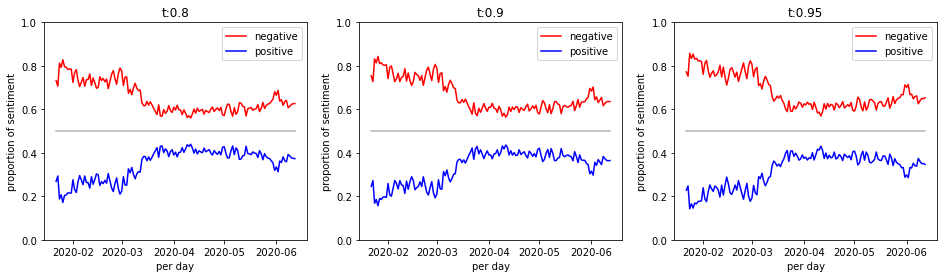

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

colslist = ['t:0.8', 't:0.9', 't:0.95']

for i, col in enumerate(colslist):

    ndf = raw[raw[col] == 1].groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())

    ax[i].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
    ax[i].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
    ax[i].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[i].set_ylabel('proportion of sentiment')
    ax[i].set_xlabel('per day')
    ax[i].set_title(f'{col}')
    ax[i].set_ylim(0,1)
    ax[i].legend()
plt.show()


In [28]:
raw['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in raw[['is_negative', 'is_positive', 't:0.95']].itertuples()]
raw['NEUT'] = [1 if cat == 'NEUT' else 0 for cat in raw['category']]
raw['POS'] = [1 if cat == 'POS' else 0 for cat in raw['category']]
raw['NEG'] = [1 if cat == 'NEG' else 0 for cat in raw['category']]
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,state_abv,fips,count,t:0.8,t:0.9,t:0.95,category,NEUT,POS,NEG
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,NV,32003,1,1,1,0,NEUT,1,0,0
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,NY,36081,1,1,0,0,NEUT,1,0,0
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,AZ,04013,1,1,1,0,NEUT,1,0,0
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,AR,05119,1,1,1,1,NEG,0,0,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,AR,05119,1,1,1,1,NEG,0,0,1


# Looking at differnce between including points less than threshold as neutral category

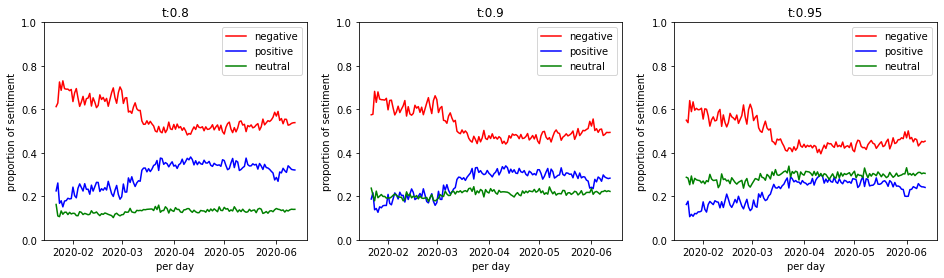

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

colslist = ['t:0.8', 't:0.9', 't:0.95']

for i, col in enumerate(colslist):

    ndf = raw

    ndf['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in ndf[['is_negative', 'is_positive', col]].itertuples()]
    ndf['NEUT'] = [1 if cat == 'NEUT' else 0 for cat in ndf['category']]
    ndf['POS'] = [1 if cat == 'POS' else 0 for cat in ndf['category']]
    ndf['NEG'] = [1 if cat == 'NEG' else 0 for cat in ndf['category']]

    ndf = ndf.groupby(['date']).agg({'NEG':'mean', 'POS':'mean', 'NEUT':'mean'}).reset_index()

    ax[i].plot(ndf['date'], ndf.NEG, color= 'r', label='negative')
    ax[i].plot(ndf['date'], ndf.POS, color = 'b', label='positive')
    ax[i].plot(ndf['date'], ndf.NEUT, color = 'g', label='neutral')
    # ax[i].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[i].set_ylabel('proportion of sentiment')
    ax[i].set_xlabel('per day')
    ax[i].set_title(f'{col}')
    ax[i].set_ylim(0,1)
    ax[i].legend()
plt.show()